In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 
pd.options.display.float_format = '{:,.2f}'.format

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv') 
# df = pd.read_csv('jammedaxis27109-infinite-matchhistory.csv')
# df.info()
# df.describe().transpose()

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] > '2024-02-04']

df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)

dfr = df[df['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
# dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
# dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0, 'Draw': 0.5})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                           (dfr['Outcome'].cumsum() + 
                            dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('dfNS.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               118 non-null    int64         
 1   Date                118 non-null    datetime64[ns]
 2   SeasonNumber        118 non-null    int64         
 3   SeasonVersion       118 non-null    int64         
 4   Map                 118 non-null    object        
 5   Category            118 non-null    object        
 6   Rank                118 non-null    int64         
 7   Outcome             118 non-null    float64       
 8   Accuracy            118 non-null    float64       
 9   DamageDone          118 non-null    int64         
 10  DamageTaken         118 non-null    int64         
 11  ShotsFired          118 non-null    int64         
 12  ShotsLanded         118 non-null    int64         
 13  ShotsMissed         118 non-null    int64         

In [4]:
dfr.tail(2)

,index,Date,SeasonNumber,SeasonVersion,Map,Category,Rank,Outcome,Accuracy,DamageDone,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
116,815,2024-03-04 02:12:48,6,1,Empyrean,CTF 3 Captures,6,0.00,51.56,5328,...,1.19,1.21,51.29,25.34,9.16,54.99,7.08,3.43,1052,0.58
117,816,2024-03-04 02:41:30,6,1,Live Fire,Oddball,3,1.00,55.15,10845,...,1.18,1.21,51.33,25.24,9.17,55.15,7.07,3.38,1059,0.58


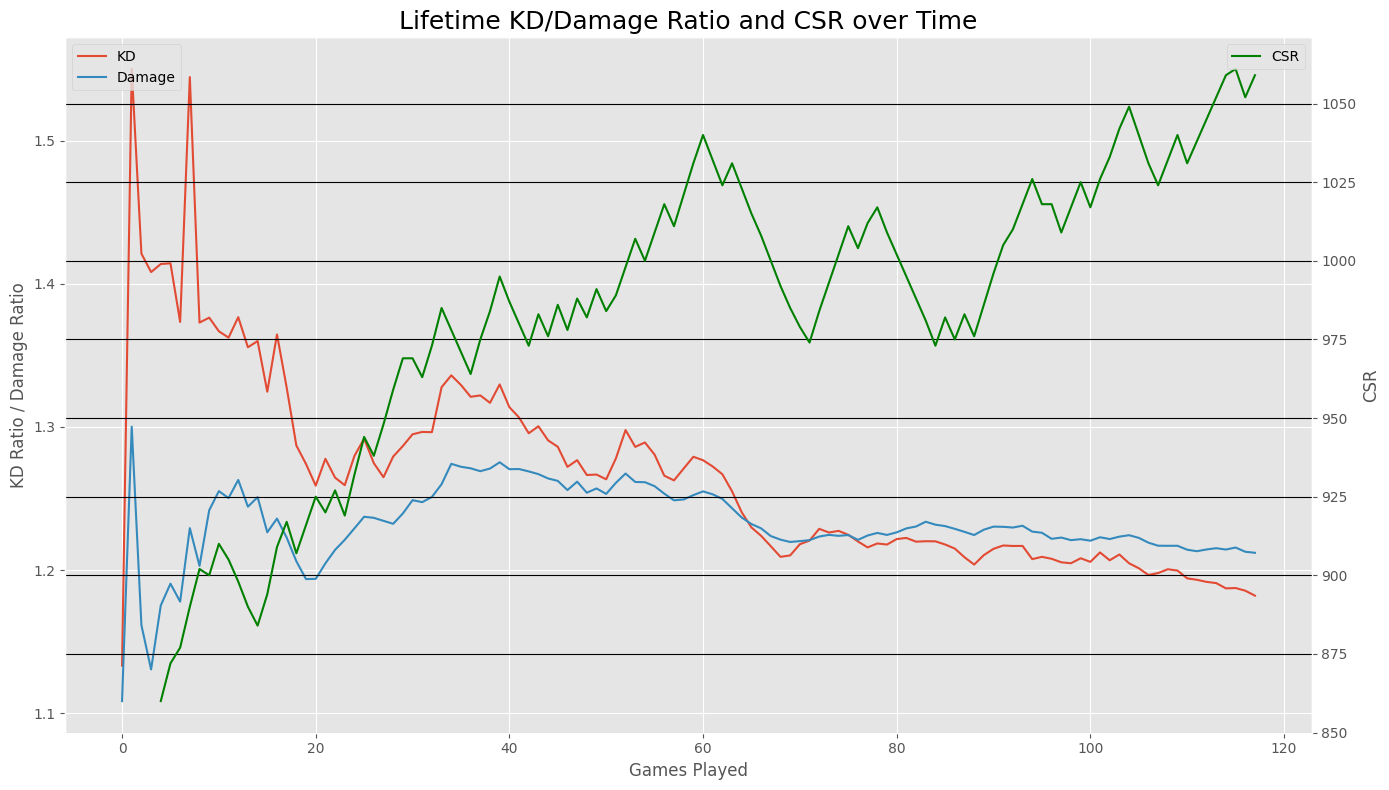

In [5]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][4:], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True, color='black')
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

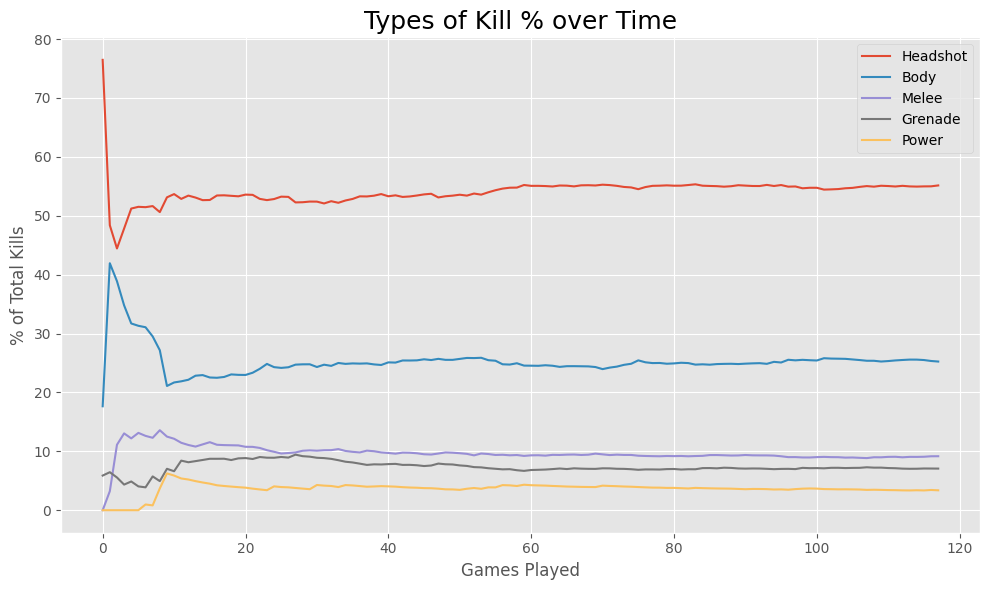

In [6]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeHSPct'], label='Headshot')
plt.plot(dfr['LifetimeBodyPct'], label='Body')
plt.plot(dfr['LifetimeMeleePct'], label='Melee')
plt.plot(dfr['LifetimeGrenadePct'], label='Grenade')
plt.plot(dfr['LifetimePowerPct'], label='Power')
plt.title('Types of Kill % over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
plt.legend(loc='best')
plt.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

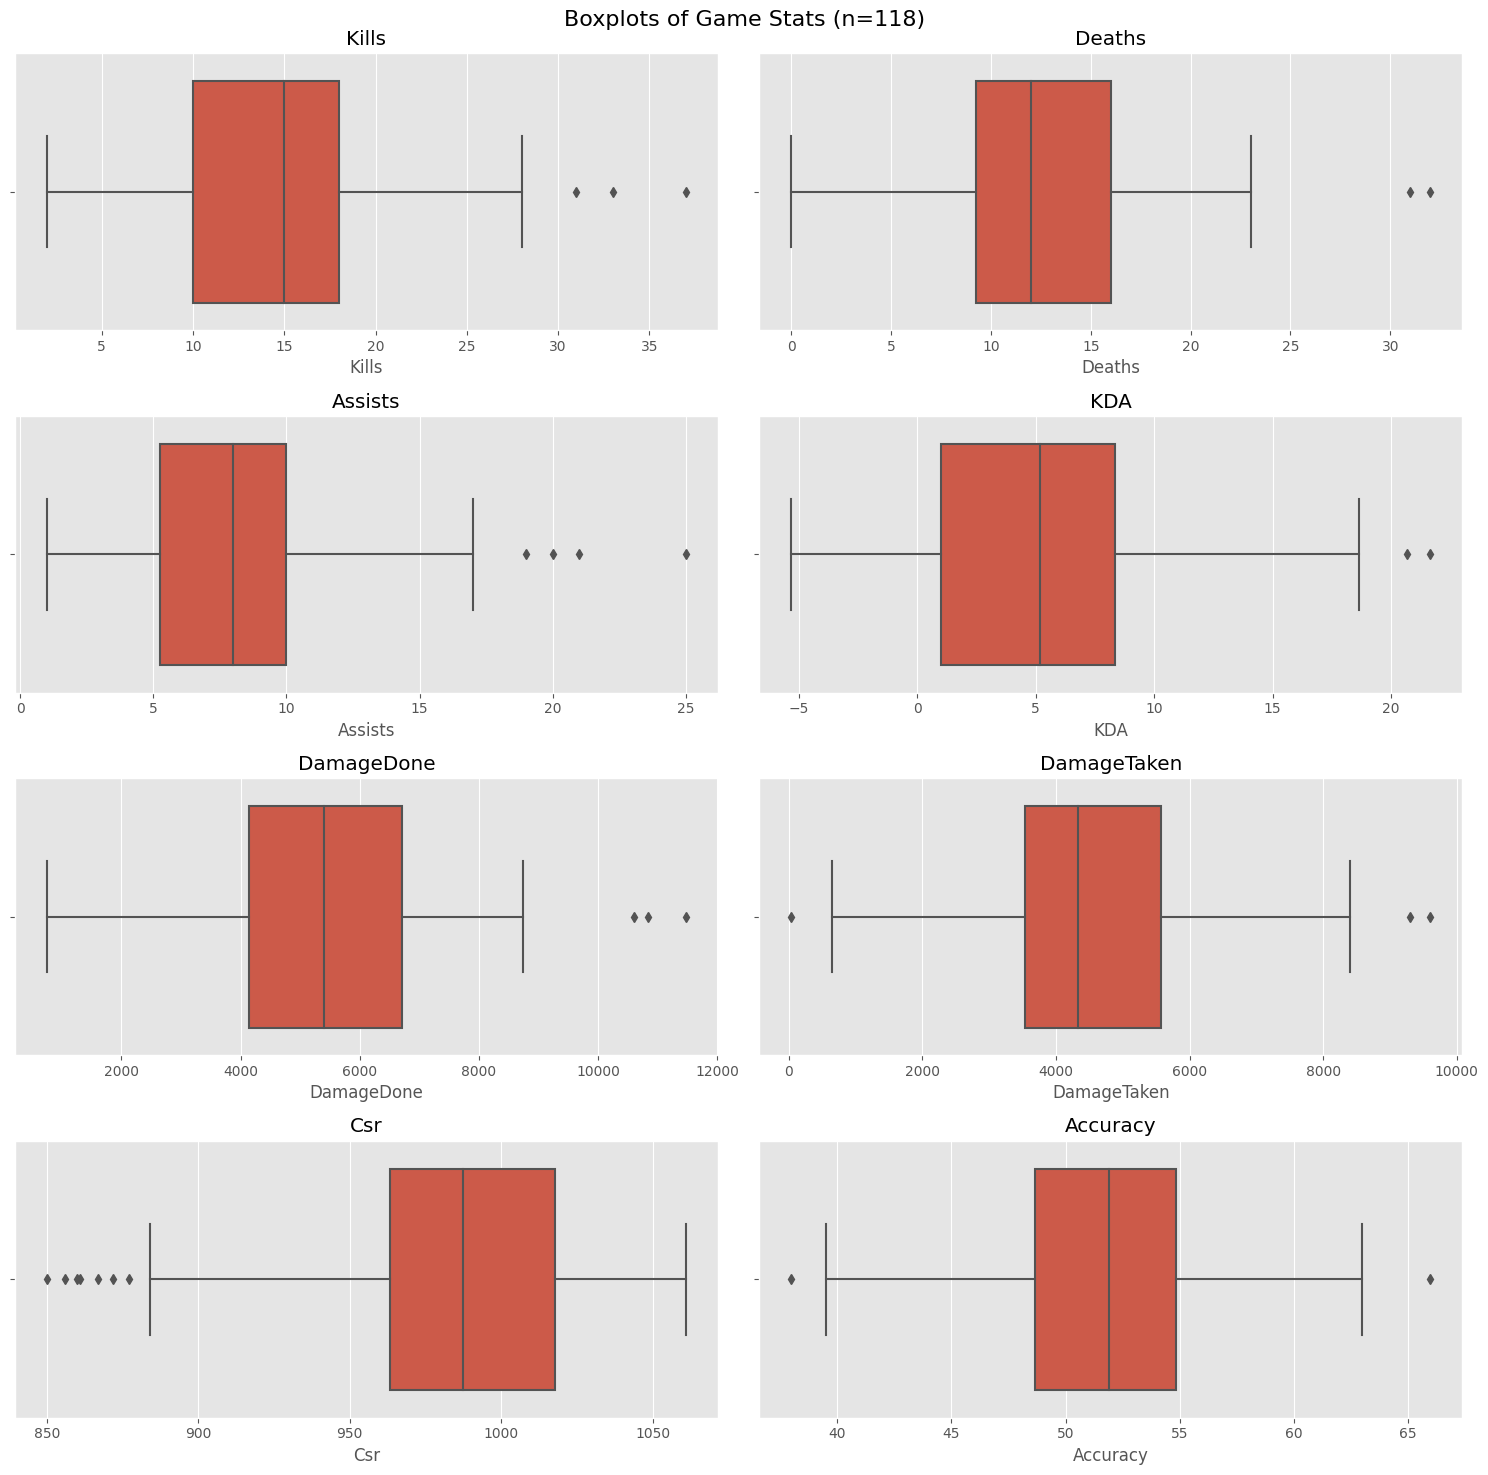

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle(f'Boxplots of Game Stats (n={len(dfr)})', fontsize=16)
plt.tight_layout()
# plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [16]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Category', 'Map'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,LengthMinutes,Accuracy,KD,DamageRatio,Dmg/Life,ExDmg/Life,Kills/10Min,Deaths/10Min,Assists/10Min,KDA/10Min
Category,Map,,,,,,,,,,,,,,,,,
Oddball,Streets,5,95,76,52,33276,25869,1.00,63.25,54.17,1.25,1.29,437.84,97.46,15.02,12.02,8.22,1.48
Slayer,Live Fire,5,53,44,30,18913,16333,1.00,41.18,52.23,1.20,1.16,429.84,58.64,12.87,10.68,7.28,1.43
King of the Hill,Live Fire,2,33,36,26,13544,12150,1.00,27.90,51.81,0.92,1.11,376.22,38.72,11.83,12.90,9.32,1.16
Oddball,Recharge,6,104,77,67,37065,27281,0.83,68.57,51.35,1.35,1.36,481.36,127.06,15.17,11.23,9.77,1.64
King of the Hill,Solitude,5,66,62,51,27604,21375,0.80,56.50,50.60,1.06,1.29,445.23,100.47,11.68,10.97,9.03,1.34
Oddball,Live Fire,5,96,88,61,34226,29936,0.80,68.80,53.15,1.09,1.14,388.93,48.75,13.95,12.79,8.87,1.32
CTF 5 Captures,Aquarius,9,168,112,74,56498,42027,0.78,95.40,54.15,1.50,1.34,504.45,129.21,17.61,11.74,7.76,1.72
Slayer,Solitude,8,92,76,69,34903,28478,0.75,65.50,50.44,1.21,1.23,459.25,84.54,14.05,11.60,10.53,1.51
Strongholds,Recharge,3,42,33,25,16550,13868,0.67,35.22,47.48,1.27,1.19,501.52,81.27,11.93,9.37,7.10,1.53


In [9]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
Oddball,16,295,241,180,104567,83086,0.88,1.22,1.26,433.89,89.13,0.75
CTF 5 Captures,9,168,112,74,56498,42027,0.78,1.50,1.34,504.45,129.21,0.66
Strongholds,14,260,192,123,85377,71342,0.57,1.35,1.20,444.67,73.10,0.64
Slayer,24,237,234,162,95484,85389,0.54,1.01,1.12,408.05,43.14,0.69
CTF 3 Captures,37,552,449,255,200315,163228,0.50,1.23,1.23,446.14,82.60,0.57
King of the Hill,18,260,252,202,107606,89511,0.44,1.03,1.20,427.01,71.81,0.80


In [10]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Live Fire,18,302,258,171,105836,90489,0.78,1.17,1.17,410.22,59.48,0.66
Solitude,18,256,207,164,92181,75257,0.72,1.24,1.22,445.32,81.76,0.79
Forbidden,11,125,81,58,44328,32059,0.64,1.54,1.38,547.26,151.47,0.72
Aquarius,12,190,143,93,68097,53294,0.58,1.33,1.28,476.20,103.52,0.65
Streets,11,145,138,87,56351,48031,0.55,1.05,1.17,408.34,60.29,0.63
Empyrean,16,279,245,121,100307,88493,0.47,1.14,1.13,409.42,48.22,0.49
Recharge,22,327,285,226,127067,104284,0.45,1.15,1.22,445.85,79.94,0.79
Argyle,10,148,123,76,55680,42676,0.40,1.20,1.30,452.68,105.72,0.62


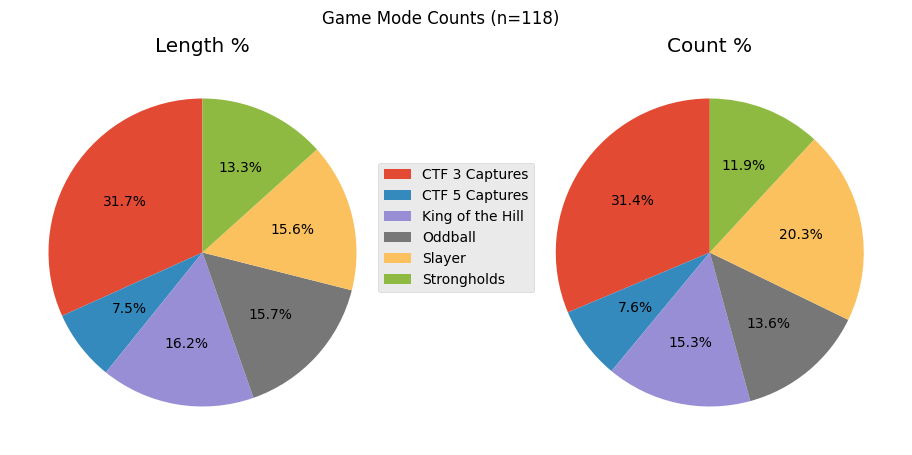

In [11]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
# Update the title of the plot to include the total game count
fig.suptitle(f'Game Mode Counts (n={totalcount})')

ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")

plt.show()

In [14]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)


print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Totals
Total Games: 118
Total Kills: 1772
Total Deaths: 1480
Total Assists: 996
----------------------------
Overall
Overall KD: 1.22
Average Kills: 13.69
Average Deaths: 11.19
Average Assists: 7.82
Average Accuracy: 51.66
Average Damage Done: 5507
Average Damage Taken: 4530
Damage Ratio: 1.22
Win-Loss: 68-49
----------------------------
Wins
Overall KD: 1.4
Average Kills: 14.53
Average Deaths: 10.37
Average Assists: 8.31
Average Accuracy: 52.53
Average Damage Done: 5440
Average Damage Taken: 4262
Damage Ratio: 1.28
Wins: 68
----------------------------
Losses
Overall KD: 1.02
Average Kills: 12.49
Average Deaths: 12.29
Average Assists: 7.14
Average Accuracy: 50.67
Average Damage Done: 5555
Average Damage Taken: 4833
Damage Ratio: 1.15
Losses: 49


In [13]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 0.8994604170002276s
